In [1]:
import astropy.units as u
import numpy as np
import popsims
import matplotlib.pyplot as plt
import astropy.coordinates as astro_coord
import glob
import pandas as pd

import itertools
from scipy import stats

from popsims.plot_style import  plot_style
plot_style()

#from shapey import Box
#paths
path_plot ='../figures/'
path_data = '../data/stream/'
isochrone_path='../data/isochrones/'
path_pipeline= '../data/pipeline/'

import warnings
warnings.filterwarnings("ignore")
from scipy.interpolate import UnivariateSpline

In [2]:
#plt.style.use('dark_background') #for posters

In [3]:
#functions
def show_gap_detection(vld,  plot='None', ax=None):
    try:
        #define
        meshgrid= vld['meshgrid']
        data=vld['data']
        grid_data = np.hstack([ xi.ravel().reshape(-1,1) for xi in meshgrid])
        gap_mask = vld['max_eigen'] > np.percentile(vld['max_eigen'],90. ) 
        stream_mask =vld['min_eigen'] < np.percentile(vld['min_eigen'],10.)
        #stream_mask=vld['density'] > np.percentile(vld['density'],70)
        #stream_mask= np.logical_or(vld['min_eigen'] < np.percentile(vld['min_eigen'], 15.),
        #                            vld['density'] > np.percentile(vld['density'],80))
        stream_size= 1*np.nanstd(meshgrid[1][stream_mask])
        weights= np.ma.masked_array(vld['density'].flatten(), mask= ~stream_mask.flatten(),
                                    fill_value=0.).filled()

        #fit a polynomial that is weighted by the density
        pol=np.poly1d(np.polyfit(meshgrid[0][stream_mask], meshgrid[1][stream_mask], 2))# w=  weights/np.nansum(weights)))
        #pol=UnivariateSpline(meshgrid[0][stream_mask], meshgrid[1][stream_mask])

        #define stream track and gap track
        stream_track=np.abs(grid_data[:,1] - pol(grid_data[:,0]))< stream_size/2

        #gap_track= np.logical_and(stream_track, gap_mask.flatten())

        #gap_center=np.nanmedian(grid_data[:,0][gap_track]) 
        #
        #gap_track1= np.logical_and.reduce([stream_track, \
        #                                  np.abs((grid_data[:,0]-gap_center)) <0.25])

        #ignore the requirement that the gap has to be inside the stream

        #new: pick a 0.5 x 0.5 kpc area centered around the gap center
        #if it's not inside the stream, no worries, density will be equal to background

        gap_center=(np.nanmedian(meshgrid[0][gap_mask]), np.nanmedian(meshgrid[1][gap_mask]))

        gap_track=np.logical_and.reduce([np.abs((grid_data[:,0]-gap_center[0])) <0.5,
                                          #np.abs((grid_data[:,1]-gap_center[1])) <0.5,
                                        stream_track])

       
        
        data_df=pd.DataFrame()
        data_df['x']=data[:,0]
        data_df['y']=data[:,1]
        
        stream_track_on_data=(np.abs(pol( data_df.x)-data_df.y)<stream_size/2).values
        gap_track_on_data=np.logical_and.reduce([np.abs((data[:,0]-gap_center[0])) <0.5,
                                             #np.abs((data[:,1]-gap_center[1])) <0.5,
                                               stream_track_on_data ])


        nstars_stream=len( data_df[np.abs(pol( data_df.x)-data_df.y)<stream_size/2])
        nstars_bck=len( data_df[(np.abs(pol( data_df.x)-data_df.y)>=stream_size/2)])
        nstars_gap=len( data_df[gap_track_on_data])

        #verify
        stream_area=10*(len(grid_data[:,0][stream_track])+len(grid_data[:,1][stream_track]))/len(grid_data.flatten())
        
        bck_area=10*(len(grid_data[:,0][~stream_track])+len(grid_data[:,1][~stream_track]))/len(grid_data.flatten())
        #print (stream_area)
        
        gap_area=2*stream_size*0.5#10*(len(grid_data[:,0][gap_track])+len(grid_data[:,1][gap_track]))/len(grid_data.flatten())
        
        
        #fig, ax=plt.subplots()
        
        #ax.scatter(data_df.x, data_df.y,  s=10)
        #ax.scatter(data[:,0], data[:,1], c= gap_track_on_data, s=10, cmap='Greys')
        #ax.scatter(data[:,0], data[:,1], c= stream_track_on_data, s=10, cmap='coolwarm')
        
       
        #ax.scatter(grid_data[:,0], grid_data[:,1], c= stream_track, s=10, cmap='Greys')
        #c=ax.scatter(grid_data[:,0], grid_data[:,1], c= gap_track, s=1, cmap='Greys')
        #plt.colorbar(c)
        #bjk
        
        
        #print (data[:,0])
        
        #masked_grid = np.ma.array(grid_data, mask= ~np.column_stack((stream_track, stream_track)))
        #nar_bck=masked_grid.filled(np.nan).flatten()
        #bck_area=10*(len(nar[~np.isnan(nar_bck)])/len(nar_bck))

        #masked_grid_gap = np.ma.array(grid_data, mask= np.column_stack((gap_track, gap_track)))
        #narg=masked_grid_gap.filled(np.nan).flatten()
        #gap_area=10*(len(narg[~np.isnan(narg)])/len(narg))
        
        #verify
        
        


        #if gap mask falls outside the stream
        #if len(grid_data[:,0][gap_track])==0 or len(grid_data[:,0][gap_track1])==0:
        #    #
        #else:
        #create mask for the gap


        #gap_track_on_data=np.logical_and.reduce([stream_track_on_data, \
        #                              np.abs((data[:,0]-gap_center)) <0.25])



        #verify
        #

        #count the fraction of the area that's cover by gap
        #verify
        # masked_grid_gap = np.ma.array(grid_data, mask= ~np.column_stack((gap_track1, gap_track1)))

        #verify


        #hjk

        #verify
        #ax.scatter(grid_data[:,0], grid_data[:,1], c=gap_track1, s=15, cmap='Greys')


        if plot=='plot1':

            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=.2, linestyle='--')
            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                              cmap='magma_r', alpha=1)
            #ax.scatter(grid_data[:,0], grid_data[:,1], c=res['max_eigen'].flatten(),
            #           s=1, cmap='cubehelix')

        if plot=='plot2':

            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['min_eigen'],  20, \
                              cmap='cubehelix', alpha=1)
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=.2, linestyle='--')
            
        if plot=='plot6':
            #ax.scatter(vld['data'][:,0], vld['data'][:,1],s=0.1, alpha=0.5, c='k')
            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                              cmap='cubehelix', alpha=0.5)
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                                            cmap='Greys', alpha=.1, linestyle='--')
            
            
            
        if plot=='plot4':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1],s=0.1, alpha=0.5, c='k')
            ax.scatter(meshgrid[0][stream_mask], meshgrid[1][stream_mask], marker='*', s=15,c='#FF851B')
            ax.scatter(meshgrid[0][gap_mask], meshgrid[1][gap_mask], marker='*', s=15,  c='#0074D9')
            
            #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#FF851B', linewidth=3)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3)

            #plot gap track
            ax.vlines(x=grid_data[:,0][gap_track].min(), \
                       ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
            ax.vlines(x=grid_data[:,0][gap_track].max(), \
                       ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])

        if plot=='plot3':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1], s=.1, alpha=1, c='k')
            #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3)

            #plot gap track
            ax.vlines(x=grid_data[:,0][gap_track].min(), \
                       ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#FF851B', linewidth=3)
            ax.vlines(x=grid_data[:,0][gap_track].max(), \
                       ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#FF851B', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])
            
            
        if plot=='plot5':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1], s=10, alpha=0.2, c='k')
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, cmap='magma_r', alpha=0.5)

            #plot stream track
            #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#0074D9', linewidth=3)
            #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#0074D9', linewidth=3)

            #plot gap track
            #ax.vlines(x=grid_data[:,0][gap_track].min(), \
            #           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
            #ax.vlines(x=grid_data[:,0][gap_track].max(), \
            #           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])

        #compute relevant statistics
        stats={'spread_stream_stars':np.nanstd(grid_data[:,1][stream_mask.flatten()]),
              'spread_gap_stars':np.nanstd(grid_data[:,0][gap_track.flatten()]),
               'nstars_gap':  nstars_gap,
               'nstars_stream':  nstars_stream,
               'nstars_bck': nstars_bck,
               'stream_farea': stream_area,
               'gap_farea': gap_area,
               'stream_dens':  nstars_stream/stream_area,
               'gap_dens':nstars_gap/gap_area,
               'bck_dens':nstars_bck/bck_area,
               'offset_center':np.nanmedian(grid_data[:,0][gap_track].max())-np.nanmedian(grid_data[:,0])
              }
        return stats
    except:
            return {'spread_stream_stars':np.nan,
                 'spread_gap_stars':np.nan,
                   'nstars_gap': np.nan,
                  'nstars_stream':  np.nan,
                   'nstars_bck': np.nan,
                   'stream_farea': np.nan,
                   'gap_farea': np.nan,
                   'stream_dens':  np.nan,
                   'gap_dens': np.nan,
                   'bck_dens': np.nan,
                    'offset_center':np.nan
                  }



In [4]:
#f.split('rgc')[-1].split('_mhalo')[0]

In [5]:
#show_gap_detection(v)

In [6]:
#k

In [7]:
df = pd.DataFrame()
for f in glob.glob('../data/pipeline/*.npy'):
    vlsx=np.load(f, allow_pickle=True)
    for vls in vlsx:
        for k in vls.keys():
            v=vls[k]
            
            #fig, ax=plt.subplots(figsize=(10, 4))
            r=pd.Series(show_gap_detection(v))#, ax=ax, plot='plot3'))
            
            r['rgc']=f.split('rgc')[-1].split('_mhalo')[0]
            r['run']=f.split('_')[-1].split('.npy')[0]
            r['mag_limit']=float(f.split('_')[-2].split('maglimit')[1])
            r['bw']=float((k.split('dmod_galaxy')[0]).split('bw')[-1])
            r['dmod']=float(k.split('dmod_galaxy')[-1])
            
            
            df=df.append(r, ignore_index=True )
    
            


In [8]:
df

,spread_stream_stars,spread_gap_stars,nstars_gap,nstars_stream,nstars_bck,stream_farea,gap_farea,stream_dens,gap_dens,bck_dens,offset_center,rgc,run,mag_limit,bw,dmod
0,0.156353,0.312972,1.0,16.0,20.0,0.722222,0.156353,22.153846,6.395784,2.155689,-0.538583,30_40,run01158,28.69,0.7,28.49
1,0.235011,0.323594,0.0,4.0,23.0,1.244444,0.235011,3.214286,0.000000,2.626904,0.049896,30_40,run01158,28.69,0.7,28.54
2,0.185618,0.239819,1.0,20.0,20.0,0.900000,0.185618,22.222222,5.387414,2.197802,0.652537,30_40,run01158,28.69,0.7,28.58
3,0.239618,0.155505,0.0,2.0,23.0,0.658824,0.239618,3.035714,0.000000,2.462217,-0.048576,30_40,run01158,28.69,0.7,28.62
4,0.253085,0.299621,0.0,8.0,31.0,1.364706,0.253085,5.862069,0.000000,3.589918,1.326197,30_40,run01158,28.69,0.7,28.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80892,0.302401,0.281647,1.0,7.0,12.0,1.710000,0.302401,4.093567,3.306870,1.447527,-0.308123,10_20,run09804,28.69,0.7,29.89
80893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10_20,run09804,28.69,0.7,29.91
80894,0.279662,0.306174,0.0,8.0,3.0,1.381818,0.279662,5.789474,0.000000,0.348101,0.491074,10_20,run09804,28.69,0.7,29.93
80895,0.140180,0.266334,1.0,6.0,11.0,0.933333,0.140180,6.428571,7.133682,1.213235,0.547444,10_20,run09804,28.69,0.7,29.96


In [9]:
df['distance']=10**((df.dmod.values/5)+1)

In [10]:
import itertools

In [11]:
rgcs=['10_20', '30_40', '50_60']
mag_limits=[27.15, 28.69]

colors={'10_20': '#0074D9',
       '30_40': '#111111',
        
       '50_60': '#FF851B' }

pairs=[x for x in list(itertools.product(rgcs, mag_limits)) ]
#combinations
pairs

[('10_20', 27.15),
 ('10_20', 28.69),
 ('30_40', 27.15),
 ('30_40', 28.69),
 ('50_60', 27.15),
 ('50_60', 28.69)]

In [12]:
df=df.reset_index(drop=True)

In [59]:
def get_counts(df, dgrid, rgc, m):
    bools=np.logical_and.reduce([(df.bw==0.7).values,\
                                 (df.rgc==rgc).values,
                                 (df.mag_limit==m).values])
    #print (bools)
    df0=(df[bools]).reset_index(drop=True)
    #jkl
    res={'gap_dens':[],
        'stream_dens':[],
        'bck_dens':[],
         'gap_stream_ratio':[],
         'stream_bck_ratio':[],
        'ds': dgrid}
    
    for idx in range(len(dgrid)-1):
        v=df0[np.logical_and(df0.distance/1e6>=dgrid[idx], df0.distance/1e6<dgrid[idx+1])]
        res['stream_dens'].append([np.nanmedian(v.stream_dens.values), np.nanstd(v.stream_dens.values)])
        res['gap_dens'].append([np.nanmedian(v.gap_dens.values), np.nanstd(v.gap_dens.values)])
        res['bck_dens'].append([np.nanmedian(v.bck_dens.values), np.nanstd(v.bck_dens.values)])
        
        gap_stream_ratio=v.gap_dens.values/v.stream_dens.values
        stream_bck_ratio=v.stream_dens.values-v.bck_dens
        res['gap_stream_ratio'].append([np.nanmedian(gap_stream_ratio), np.nanstd(gap_stream_ratio)])
        res['stream_bck_ratio'].append([np.nanmedian(stream_bck_ratio), np.nanstd( stream_bck_ratio)])

    return res

In [14]:
dgrid=np.arange(0.77, 10, .1)

In [15]:
def make_line_plot(ax, x, y, yerr, rgc, **kwargs):
    
    nans=np.logical_or.reduce([np.isnan(x), np.isnan(y), np.isnan(yerr)])
    #print (vls)
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))
    
    
    ax.plot(x[~nans], y[~nans], **kwargs)

    ax.fill_between(x[~nans], y[~nans]-yerr[~nans], y[~nans]+yerr[~nans],  alpha=0.1, color=colors[rgc])
    
    #ax.plot(dgrid[:-1], np.vstack(vls['stream_dens'])[:,0], color=colors[rgc], linestyle='-', label='Stream, Rgc={} Kpc'.format(rgcx))
    #ax[0][0].fill_between(dgrid[:-1], np.vstack(vls['stream_dens'])[:,0]-np.vstack(vls['stream_dens'])[:,1],
    #                    np.vstack(vls['stream_dens'])[:,0]+np.vstack(vls['stream_dens'])[:,1], alpha=0.1,\
    #                      color=colors[rgc])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


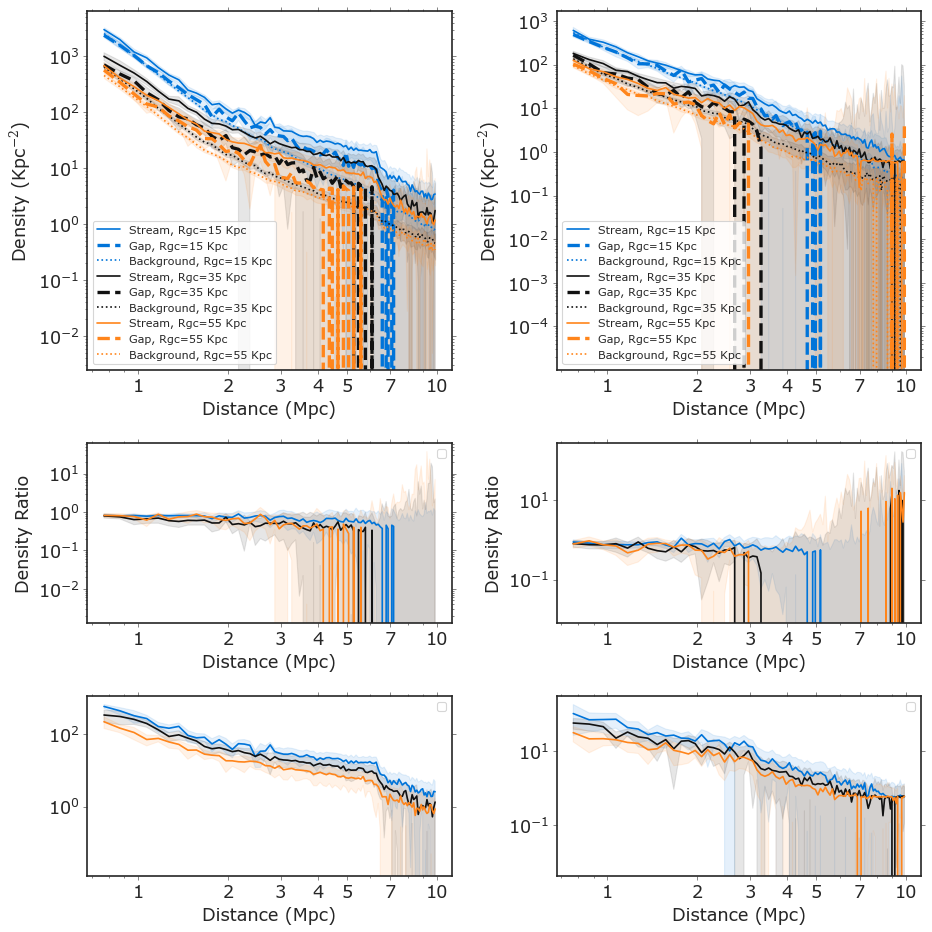

In [60]:
fig, ax=plt.subplots(figsize=(12, 12), ncols=2, nrows=3, height_ratios=[1., 0.5, 0.5])

for rgc in ['10_20', '30_40', '50_60']:
    
    vls=get_counts(df, dgrid,rgc, 28.69)
  
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))

    make_line_plot( ax[0][0], dgrid[:-1], np.vstack(vls['stream_dens'])[:,0], np.vstack(vls['stream_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Stream, Rgc={} Kpc'.format(rgcx))
    
    make_line_plot( ax[0][0], dgrid[:-1], np.vstack(vls['gap_dens'])[:,0], np.vstack(vls['gap_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle='--', label='Gap, Rgc={} Kpc'.format(rgcx), linewidth=3)
    
    make_line_plot( ax[0][0], dgrid[:-1], np.vstack(vls['bck_dens'])[:,0], np.vstack(vls['bck_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle=':', label='Background, Rgc={} Kpc'.format(rgcx))
    
    
    make_line_plot( ax[1][0], dgrid[:-1], np.vstack(vls['gap_stream_ratio'])[:,0], np.vstack(vls['gap_stream_ratio'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-')
    
    make_line_plot( ax[2][0], dgrid[:-1], np.vstack(vls['stream_bck_ratio'])[:,0], np.vstack(vls['stream_bck_ratio'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-')


    vls=get_counts(df, dgrid,rgc, 27.15)
    make_line_plot( ax[0][1], dgrid[:-1], np.vstack(vls['stream_dens'])[:,0], np.vstack(vls['stream_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Stream, Rgc={} Kpc'.format(rgcx))
    
    make_line_plot( ax[0][1], dgrid[:-1], np.vstack(vls['gap_dens'])[:,0], np.vstack(vls['gap_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle='--', label='Gap, Rgc={} Kpc'.format(rgcx), linewidth=3)
    
    make_line_plot( ax[0][1], dgrid[:-1], np.vstack(vls['bck_dens'])[:,0], np.vstack(vls['bck_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle=':', label='Background, Rgc={} Kpc'.format(rgcx))
    
    make_line_plot( ax[1][1], dgrid[:-1], np.vstack(vls['gap_stream_ratio'])[:,0], np.vstack(vls['gap_stream_ratio'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-')
    
    make_line_plot( ax[2][1], dgrid[:-1], np.vstack(vls['stream_bck_ratio'])[:,0], np.vstack(vls['stream_bck_ratio'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-')


#ax[1][0].axhline(1, linestyle='--', color='k')
#ax[1][1].axhline(1, linestyle='--', color='k')
for a in np.concatenate(ax):
    a.minorticks_on()
    a.legend(fontsize=10)
    a.set(xscale='log',  yscale='log', xticks=[1, 2, 3, 4, 5, 7, 10],xticklabels=[1, 2, 3, 4, 5, 7, 10], xlabel='Distance (Mpc)')

#ax[0][0].set(yscale='log', ylim=[1e-1, 5e3])
#ax[0][1].set(yscale='log', ylim=[1e-1, 5e3])

ax[0][0].set(ylabel=r'Density (Kpc$^{-2}$)')
ax[0][1].set(ylabel=r'Density (Kpc$^{-2}$)')


ax[1][0].set(ylabel=r'Density Ratio')
ax[1][1].set(ylabel=r'Density Ratio')

#ax[1][0].set(ylim=[-2, 2])
#ax[1][1].set(ylim=[-2, 2])
plt.tight_layout()

plt.savefig('../figures/gap_density_number.pdf')

In [17]:
def get_pipeline_results(dmod, mag_limit, rgc):
    fls=glob.glob('../data/pipeline/pipeline_rgc{}_mhalo5.00e+06_maglimit{:.2f}_run*.npy'.format(rgc, mag_limit))
    #print (fls
    res=None
    for f in fls:
        c=np.load(f, allow_pickle=True)
        for vls in c:
            for k in vls.keys():
                bw=(k.split('dmod_galaxy')[0]).split('bw')[-1]
                dmodx=float(k.split('dmod_galaxy')[-1])
                if (dmod ==dmodx) and (bw=='0.7'):
                    return vls[k]
                else:
                    continue

def get_pipeline_results_full(dmod, mag_limit, rgc):
    fls=glob.glob('../data/pipeline/pipeline_rgc{}_mhalo5.00e+06_maglimit{:.2f}_run*.npy'.format(rgc, mag_limit))
    #print (fls
    res=[]
    for f in fls:
        c=np.load(f, allow_pickle=True)
        for vls in c:
            for k in vls.keys():
                bw=(k.split('dmod_galaxy')[0]).split('bw')[-1]
                dmodx=float(k.split('dmod_galaxy')[-1])
                if (dmod ==dmodx) and (bw=='0.7'):
                    res.append(vls[k])
                else:
                    continue
    return res
res=get_pipeline_results(24.06, 28.69, '10_20')

In [18]:
res=get_pipeline_results_full(24.06, 28.69, '10_20')
#res

In [19]:
dmods=np.unique(df.dmod.values[np.logical_and(df.distance/1e6 <10, df.distance/1e6 > 0.7) ])[::6]

In [20]:
len(dmods)

23

In [21]:
 from matplotlib import patches

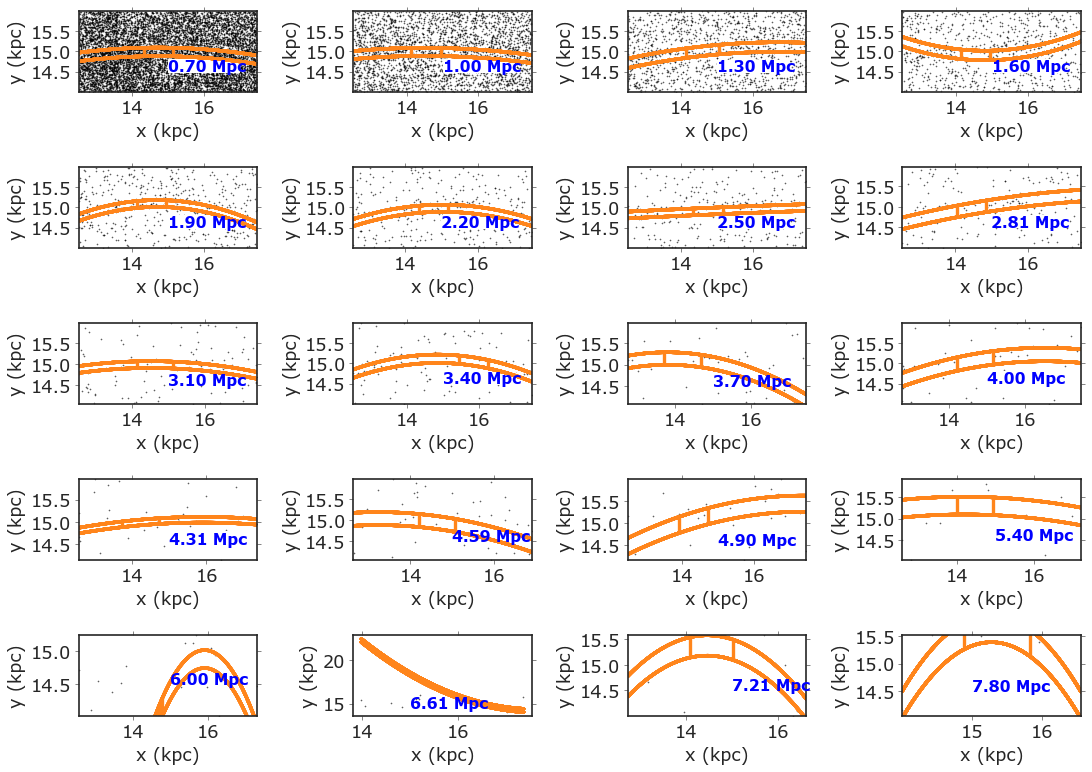

In [22]:
fig, ax=plt.subplots(ncols=4, nrows=int(len(dmods)/4), figsize=(14, 2*int(len(dmods)/4)))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods[idx]
    res=get_pipeline_results(dmod, 27.15, '10_20')
    _=show_gap_detection(res,  plot='plot3', ax=a)
    title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1)))
    
    rect = patches.Rectangle( (15,14.5), \
                               2, 0.3, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(15, 14.5, title,\
           color='b', alpha=1, fontsize=14, weight='bold')
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
#ax.scatter(res['meshgrid'][0], res['meshgrid'][1], marker='+', alpha=0.1)
plt.tight_layout()
plt.savefig('../figures/visual_detections_rgc15.jpeg')

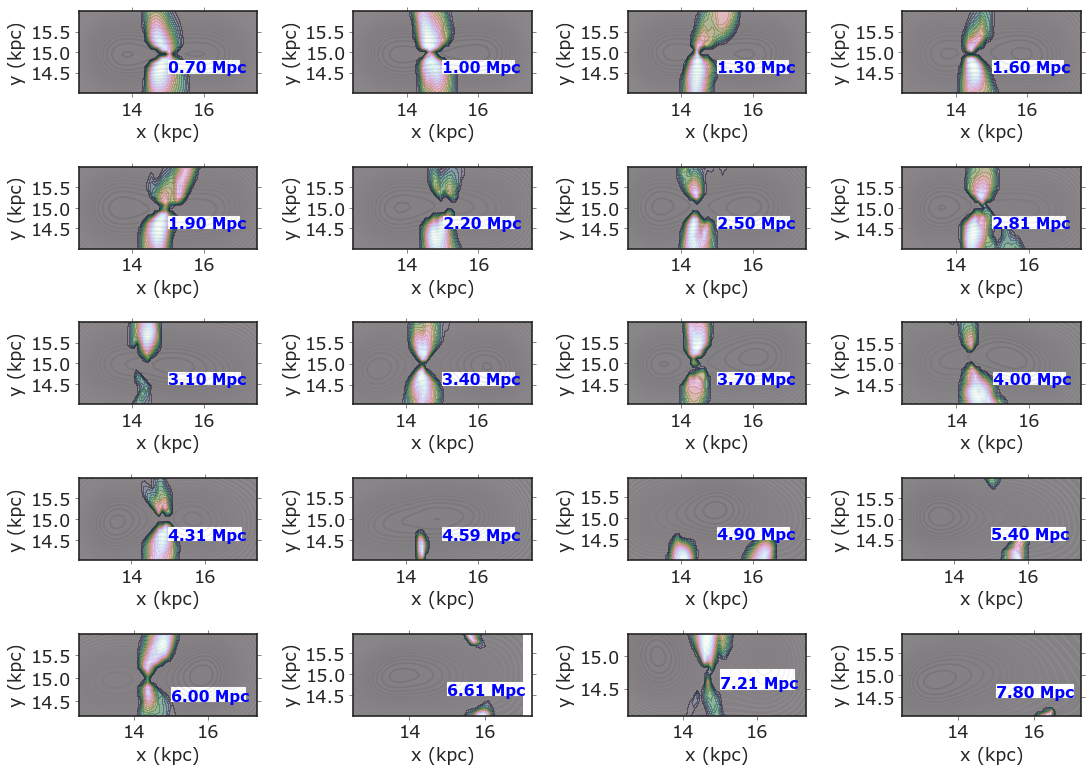

In [23]:
fig, ax=plt.subplots(ncols=4, nrows=int(len(dmods)/4), figsize=(14, 2*int(len(dmods)/4)))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods[idx]
    res=get_pipeline_results(dmod, 28.69, '10_20')
    #resx=get_pipeline_results_full(dmod, 28.69, '10_20')
    #for res in resx:
    _=show_gap_detection(res,  plot='plot6', ax=a)
    title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1)))
    
    rect = patches.Rectangle( (15,14.5), \
                               2, 0.3, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(15, 14.5, title,\
           color='b', alpha=1, fontsize=14, weight='bold')
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
#ax.scatter(res['meshgrid'][0], res['meshgrid'][1], marker='+', alpha=0.1)
plt.tight_layout()
plt.savefig('../figures/visual_detections_rgc15_piHpi.jpeg')

In [24]:
from popsims.plot_tools import plot_annotated_heatmap


In [25]:

#df['prod']=df.spread_gap_stars/df.spread_stream_stars
df.offset_center=np.abs(df.offset_center)

In [26]:
#dmods

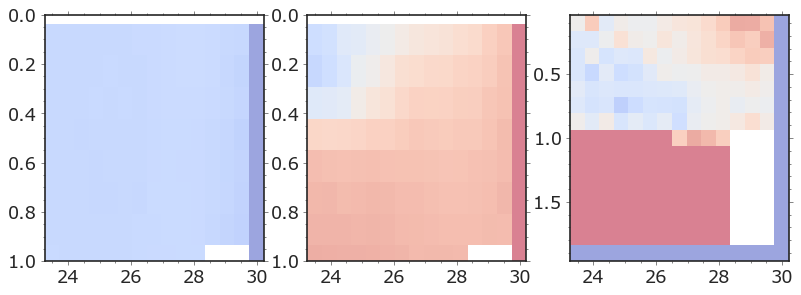

In [34]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))

#ax[0].scatter(  df.dmod, df.bw, c=df.spread_gap_stars , s=0.1, cmap='cubehelix')
#ax[1].scatter(df.dmod, df.bw, c=df.spread_stream_stars, s=0.1, cmap='cubehelix')
plot_annotated_heatmap(ax[0], df, 15, ['dmod', 'bw', 'spread_gap_stars'], cmap='coolwarm',annotate=True,  alpha=0.5)

plot_annotated_heatmap(ax[1], df, 15, ['dmod', 'bw', 'spread_stream_stars'], cmap='coolwarm_r',annotate=False, alpha=0.5)
plot_annotated_heatmap(ax[-1], df, 15, ['dmod', 'bw', 'offset_center'], cmap='coolwarm',annotate=False, alpha=0.5)

#ax[0].scatter(df.dmod, df.bw, s=.1)


In [28]:
ds=([0.77, 1., 1.5, 2., 2.5, 3.])*u.Mpc
dmods2 = 5*np.log10(ds.to(u.pc)/(10*u.pc)).value

dmods2

array([24.43245363, 25.        , 25.8804563 , 26.50514998, 26.98970004,
       27.38560627])

In [29]:
np.unique(df.dmod.values)

array([23.49, 23.7 , 23.89, 24.06, 24.23, 24.38, 24.52, 24.65, 24.77,
       24.89, 25.  , 25.11, 25.21, 25.3 , 25.4 , 25.48, 25.57, 25.65,
       25.73, 25.81, 25.88, 25.95, 26.02, 26.09, 26.15, 26.22, 26.28,
       26.34, 26.39, 26.45, 26.51, 26.56, 26.61, 26.66, 26.71, 26.76,
       26.81, 26.86, 26.9 , 26.95, 26.99, 27.03, 27.07, 27.12, 27.16,
       27.2 , 27.24, 27.27, 27.31, 27.35, 27.39, 27.42, 27.46, 27.49,
       27.53, 27.56, 27.59, 27.63, 27.66, 27.69, 27.72, 27.75, 27.78,
       27.81, 27.84, 27.87, 27.9 , 27.93, 27.96, 27.98, 28.01, 28.04,
       28.06, 28.09, 28.12, 28.14, 28.17, 28.19, 28.22, 28.24, 28.27,
       28.29, 28.31, 28.34, 28.36, 28.38, 28.41, 28.43, 28.45, 28.47,
       28.49, 28.54, 28.58, 28.62, 28.66, 28.7 , 28.74, 28.78, 28.82,
       28.85, 28.89, 28.93, 28.96, 29.  , 29.03, 29.06, 29.1 , 29.13,
       29.16, 29.19, 29.23, 29.26, 29.29, 29.32, 29.35, 29.38, 29.4 ,
       29.43, 29.46, 29.49, 29.52, 29.54, 29.57, 29.6 , 29.62, 29.65,
       29.67, 29.7 ,

In [30]:
dmods2=[ 24.52,  25.  , 25.88, 26.51, 26.99, 27.39]

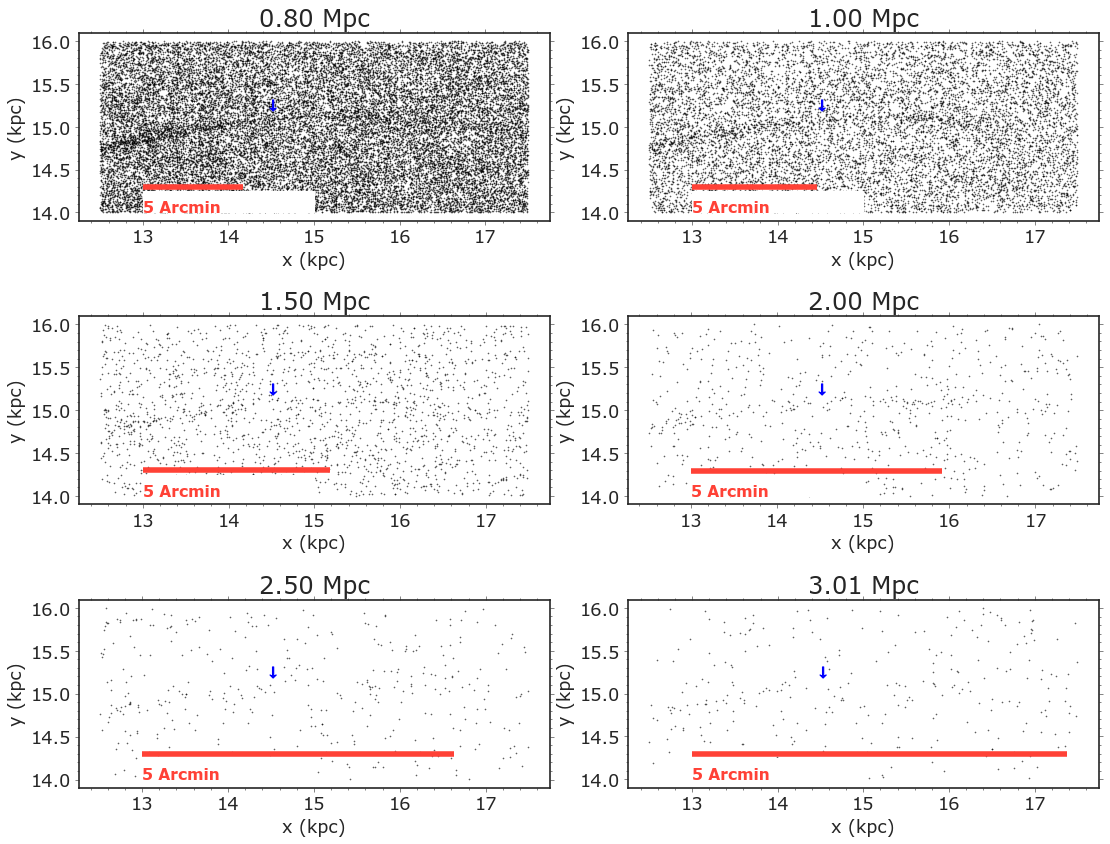

In [31]:
fig, ax=plt.subplots(nrows=3, ncols=2, figsize=(14, 10.9))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods2[idx]
    
    res=get_pipeline_results(dmod, 28.69, '10_20')
    #_=show_gap_detection(res,  plot='plot3', ax=a)
    dmod=float(dmod)
    a.scatter(res['data'][:,0], res['data'][:,1], s=0.1, alpha=1, c='k')
    a.minorticks_on()
    a.axis('equal')
    
    d_galaxy=(1e-3*(10**((dmod/5)+1)))*u.kpc
    kpc_conversion = np.pi * d_galaxy / 180.
    roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)
    scaled_arcmin= 5*u.arcmin.to(u.degree)*(kpc_conversion /u.degree).value
    
    
    a.hlines(y=14.3, xmin= 13, xmax=13+scaled_arcmin, \
             linewidth=5, color='#FF4136')
    
    rect = patches.Rectangle( (13,14), \
                               2, 0.25, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(13, 14., '5 Arcmin',\
           color='#FF4136', alpha=1, fontsize=14, weight='bold')
    
    a.scatter(14.5,  15.0+0.25, color='b', marker='$\u2193$', s=100)

    a.set(title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1))), xlabel='x (kpc)', ylabel='y (kpc)')

plt.tight_layout()
plt.savefig('../figures/gaps_visual_detections.jpeg')

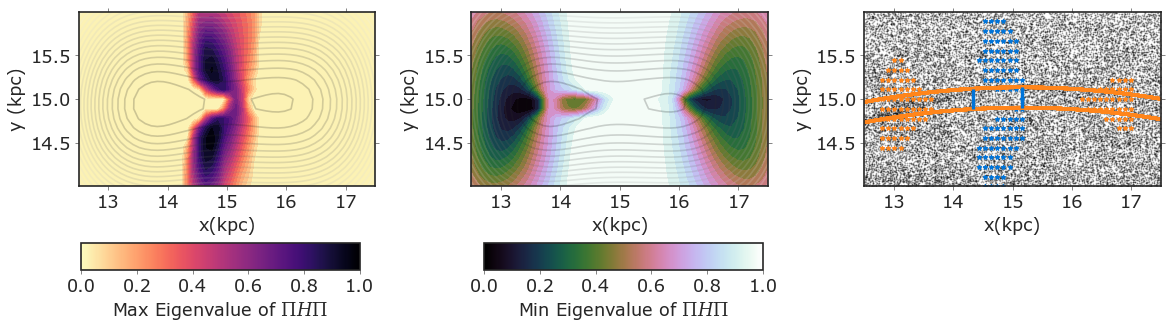

In [32]:
res=get_pipeline_results(dmods2[0], 28.69, '10_20')

import matplotlib as mpl

fig, ax=plt.subplots(ncols=3, figsize=(10*1.5, 2.25*1.5))

#ax[-1].scatter(res['data'][:,0], res['data'][:,1], s=0.1, alpha=1, c='k')
_= show_gap_detection(res,  plot='plot1', ax=ax[0])
_= show_gap_detection(res,  plot='plot2', ax=ax[1])
_= show_gap_detection(res,  plot='plot4', ax=ax[-1])


cmap = mpl.cm.magma_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.079, -0.05, 0.232, 0.1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Max Eigenvalue of $\Pi H \Pi$')


cmap = mpl.cm.cubehelix
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.415, -0.05, 0.232, 0.1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Min Eigenvalue of $\Pi H \Pi$')

for a in ax:
    a.set(xlabel='x(kpc)', ylabel='y (kpc)')
    #a.axis('equal')
plt.tight_layout()

plt.savefig('../figures/stream_cutout.jpeg', bbox_inches='tight')